In [2]:
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import scanpy as sc
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from vae_v6 import *

sc.set_figure_params(figsize=(5, 5))

Seed set to 42


# Micropattern

In [2]:
adata = sc.read_h5ad("../data/adata_timeseries_all_cc_hvg1000_leiden10_23_v3.h5ad")
adata = adata[adata.obs["sample_labels"].str.contains("48h-1|72h-1")].copy()
obs_idx = np.arange(adata.shape[0], dtype=np.int64)

# adata is already log transformed
# neighbor calculation for each batch
adata_list = []
start_obs_idx = 0
n_neighbors = 10
obs_nei_idx = -np.ones([adata.shape[0], n_neighbors], dtype=np.int64)
obs_nei_conn = np.zeros([adata.shape[0], n_neighbors], dtype=np.float32)
for sp in tqdm(adata.obs["sample_labels"].cat.categories):
    adata_temp = adata[adata.obs["sample_labels"] == sp].copy()
    sc.pp.pca(adata_temp, n_comps=100)
    sc.pp.neighbors(adata_temp, method="gauss", n_neighbors=n_neighbors)
    row_idx, col_idx = adata_temp.obsp["connectivities"].nonzero()
    conn = adata_temp.obsp["connectivities"].data
    for i in np.unique(row_idx):
        nei_idx = col_idx[row_idx == i] + start_obs_idx
        nei_conn = conn[row_idx == i]
        # in case there are more than n_neighbors, get n_neighbors closest
        if len(nei_idx) > n_neighbors:
            # Sort by connection strength (descending) and keep top n_neighbors
            sorted_indices = np.argsort(nei_conn)[::-1][:n_neighbors]
            nei_idx = nei_idx[sorted_indices]
            nei_conn = nei_conn[sorted_indices]
        obs_nei_idx[i + start_obs_idx, 0 : len(nei_idx)] = nei_idx
        obs_nei_conn[i + start_obs_idx, 0 : len(nei_idx)] = nei_conn
    adata_list.append(adata_temp)
    start_obs_idx += adata_temp.shape[0]
adata = sc.concat(adata_list)

100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


In [3]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
x = adata.X.toarray().round()
c = pd.get_dummies(adata.obs["sample_labels"]).values
x = torch.from_numpy(x.astype(np.float32))
c = torch.from_numpy(c.astype(np.float32))
obs_idx = torch.from_numpy(obs_idx)
obs_nei_idx = torch.from_numpy(obs_nei_idx)
obs_nei_conn = torch.from_numpy(obs_nei_conn)

In [4]:
dataset = TensorDataset(x, c, obs_idx, obs_nei_idx, obs_nei_conn)
data_loader = DataLoader(dataset, batch_size=1024 * 2, shuffle=True)

In [25]:
# --- Model setup ---
input_dim = x.shape[1]
condition_dim = c.shape[1]
hidden_dim = 64
latent_dim = 30
output_dim = x.shape[1]

# Instantiate Encoder and Decoder
encoder = Encoder(
    input_dim=input_dim,
    condition_dim=condition_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
)

decoder = Decoder(
    output_dim=output_dim,
    condition_dim=condition_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
)

# Instantiate the HVAE model
model = HVAE(
    Encoder=encoder,
    Decoder=decoder,
    nLeapFrog=20,
    LeapFrogStep=0.1,
    Temp0=1.0,
    lr=1e-3,
    beta=1.0,
    GraphRegWeight=0.0,
    MMD=0.1,
    MMDdim=latent_dim,
    MMDgamma=0.5,
)

# --- Training ---
# Use PyTorch Lightning's Trainer
# You can add callbacks, logging, etc. here
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",  # Automatically selects GPU/CPU
)

# Train the model
trainer.fit(model, data_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | Encoder | Encoder | 72.1 K | train
1 | Decoder | Decoder | 70.1 K | train
--------------------------------------------
142 K     Trainable params
0         Non-trainable params
142 K     Total params
0.569     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
/home/stanfish/Git/vae/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num

Epoch 29: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s, v_num=135, loss=2.14e+3]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s, v_num=135, loss=2.14e+3]


In [26]:
_, _, _, _, z_k, _ = model.forward(x, c)
z_k = z_k.detach().numpy()
adata.obsm["X_vae"] = z_k
del z_k

In [27]:
sc.pp.neighbors(adata, use_rep="X_vae", key_added="vae", n_neighbors=50, method="gauss")
sc.tl.diffmap(adata, neighbors_key="vae")
sc.tl.umap(adata, neighbors_key="vae")
adata.obsm["X_diffmap_vae"] = adata.obsm["X_diffmap"]

Text(0.5, 1.0, 'Hamiltonian VAE enables more flexible latent manifold')

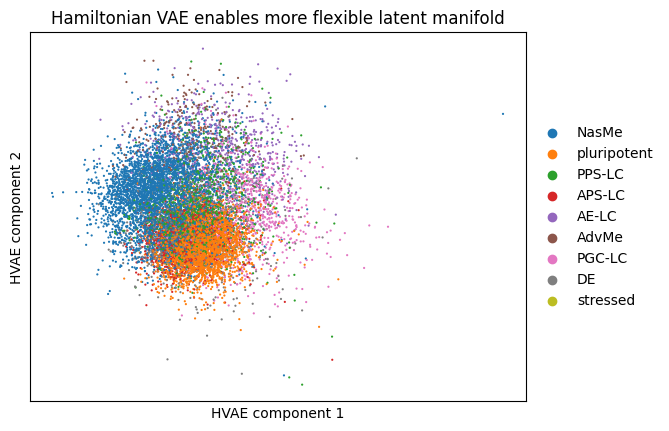

In [28]:
ax = sc.pl.embedding(
    adata, color=["leiden"], basis="X_vae", components="1,2", show=False
)
ax.set_xlabel("HVAE component 1")
ax.set_ylabel("HVAE component 2")
ax.set_title("Hamiltonian VAE enables more flexible latent manifold")
# plt.savefig(
#     "/home/stanfish/zhiyu/Desktop/HVAE_latent.png", dpi=300, bbox_inches="tight"
# )

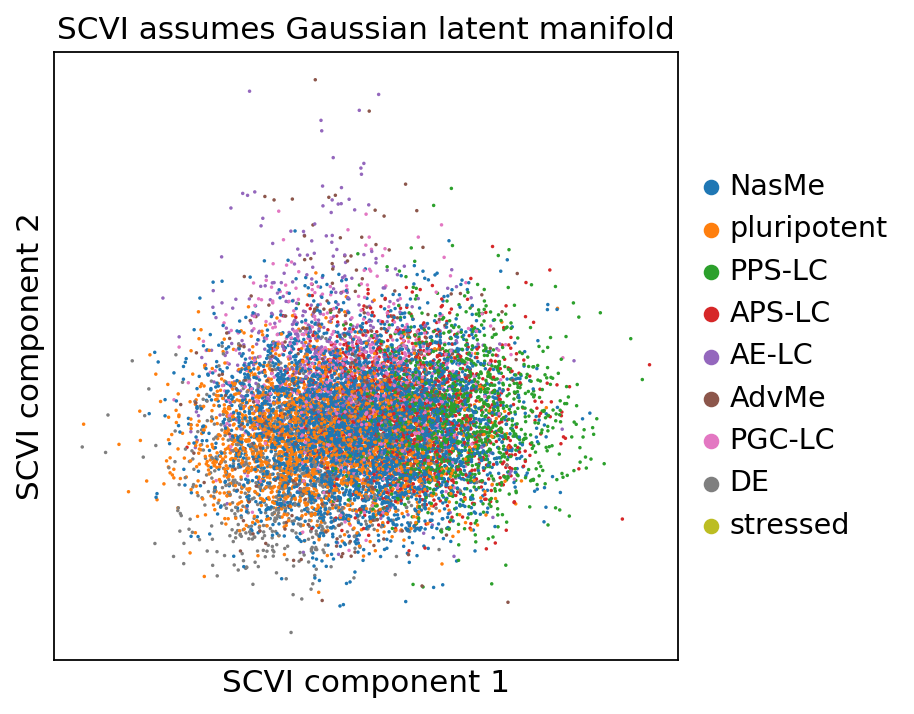

In [ ]:
ax = sc.pl.embedding(
    adata, color=["leiden"], basis="X_scVI_cc", components="1,2", show=False
)
ax.set_xlabel("SCVI component 1")
ax.set_ylabel("SCVI component 2")
ax.set_title("SCVI assumes Gaussian latent manifold")
plt.savefig(
    "/home/stanfish/zhiyu/Desktop/SCVI_latent.png", dpi=300, bbox_inches="tight"
)

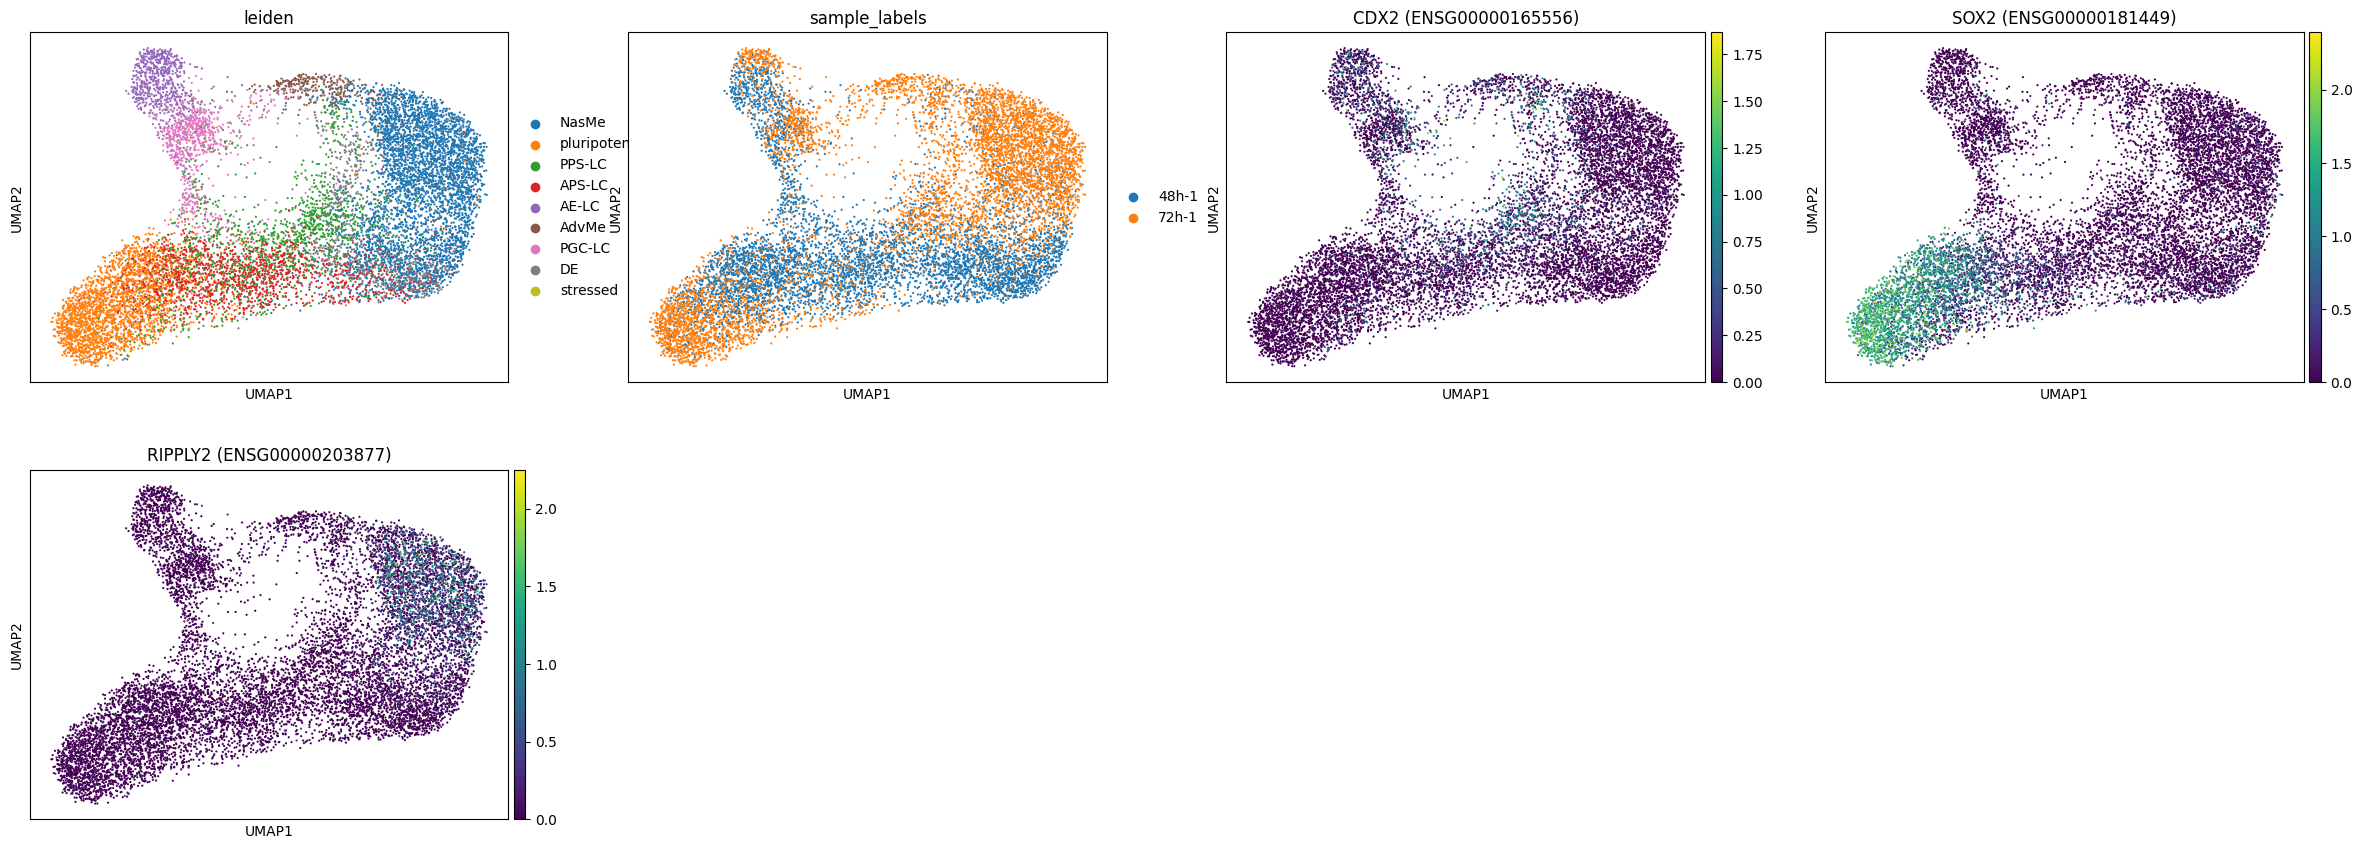

In [29]:
sc.pl.umap(
    adata,
    color=["leiden", "sample_labels"]
    + list(adata.var_names[adata.var_names.str.contains("SOX2|CDX2|RIPPLY2")]),
)

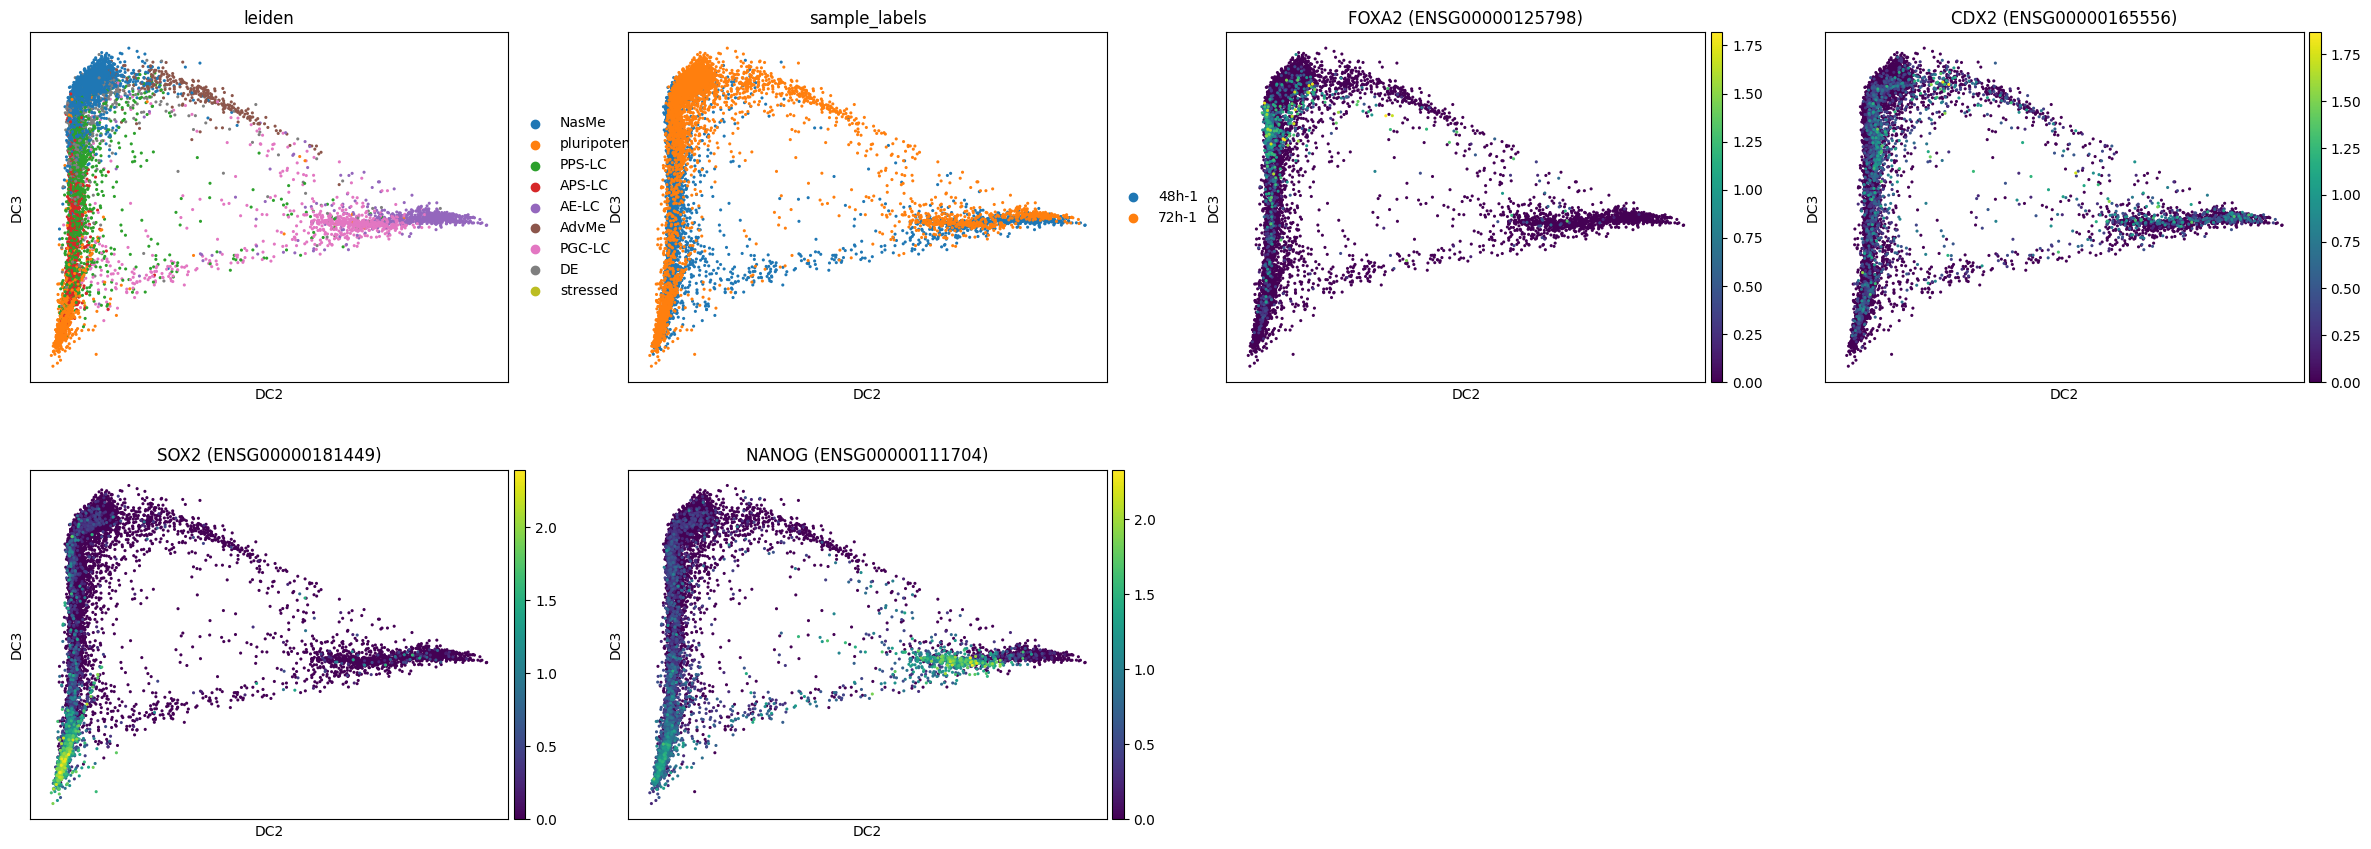

In [34]:
sc.pl.diffmap(
    adata,
    components="2,3",
    color=["leiden", "sample_labels"]
    + list(adata.var_names[adata.var_names.str.contains("SOX2|FOXA2|NANOG|CDX2")]),
    size=20,
)

In [38]:
sc.pp.neighbors(
    adata, use_rep="X_scVI_cc", key_added="scvi", n_neighbors=50, method="gauss"
)
sc.tl.diffmap(adata, neighbors_key="scvi")
# sc.tl.umap(adata, neighbors_key="scvi")

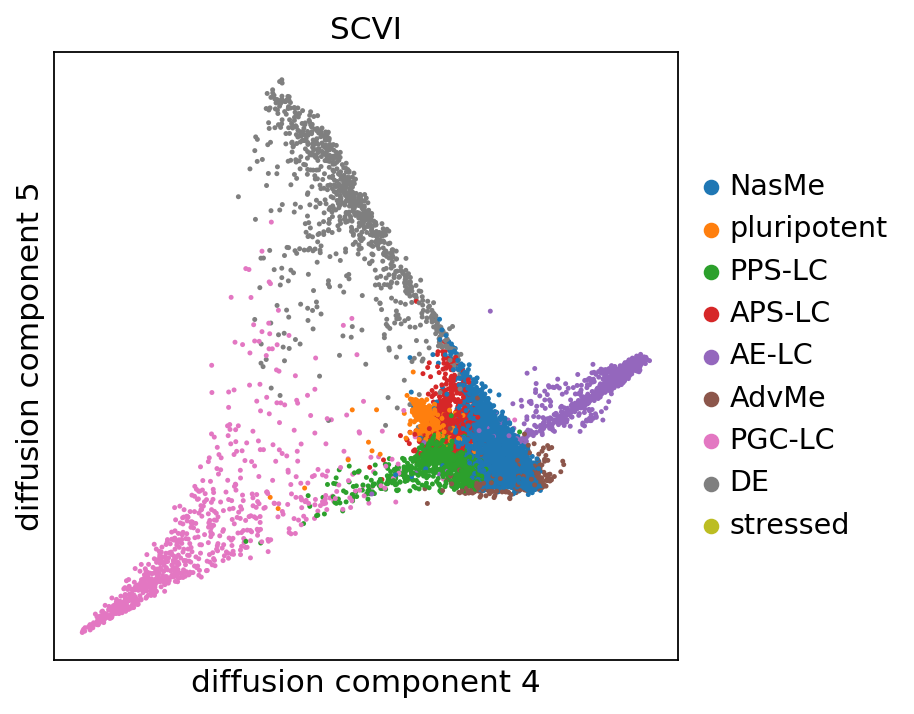

In [ ]:
ax = sc.pl.diffmap(adata, components="4,5", color=["leiden"], size=20, show=False)
ax.set_xlabel("diffusion component 4")
ax.set_ylabel("diffusion component 5")
ax.set_title("SCVI")
plt.savefig("/home/stanfish/zhiyu/Desktop/scvi.png", dpi=300, bbox_inches="tight")

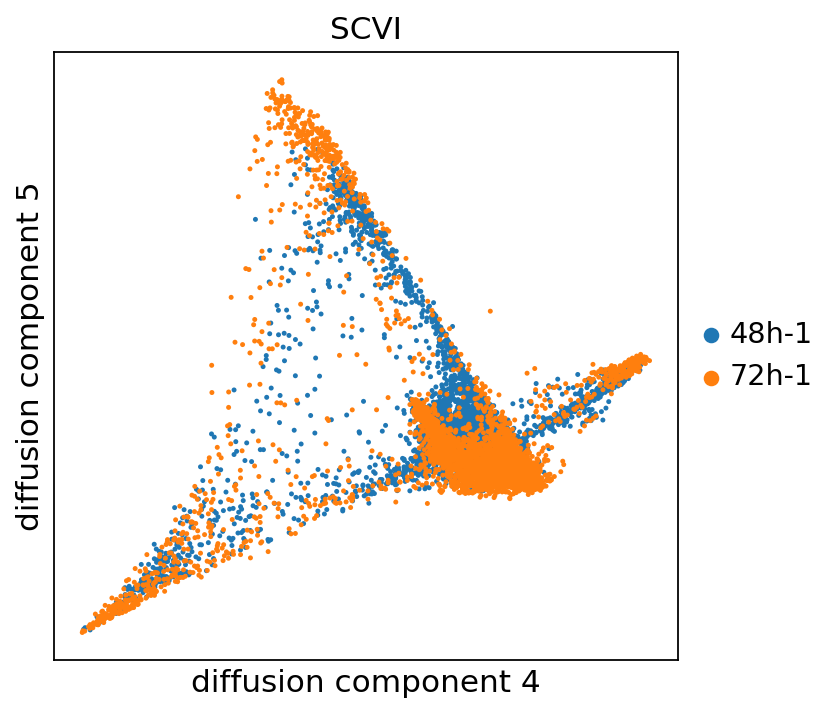

In [ ]:
ax = sc.pl.diffmap(
    adata, components="4,5", color=["sample_labels"], size=20, show=False
)
ax.set_xlabel("diffusion component 4")
ax.set_ylabel("diffusion component 5")
ax.set_title("SCVI")
plt.savefig("/home/stanfish/zhiyu/Desktop/scvi_sl.png", dpi=300, bbox_inches="tight")

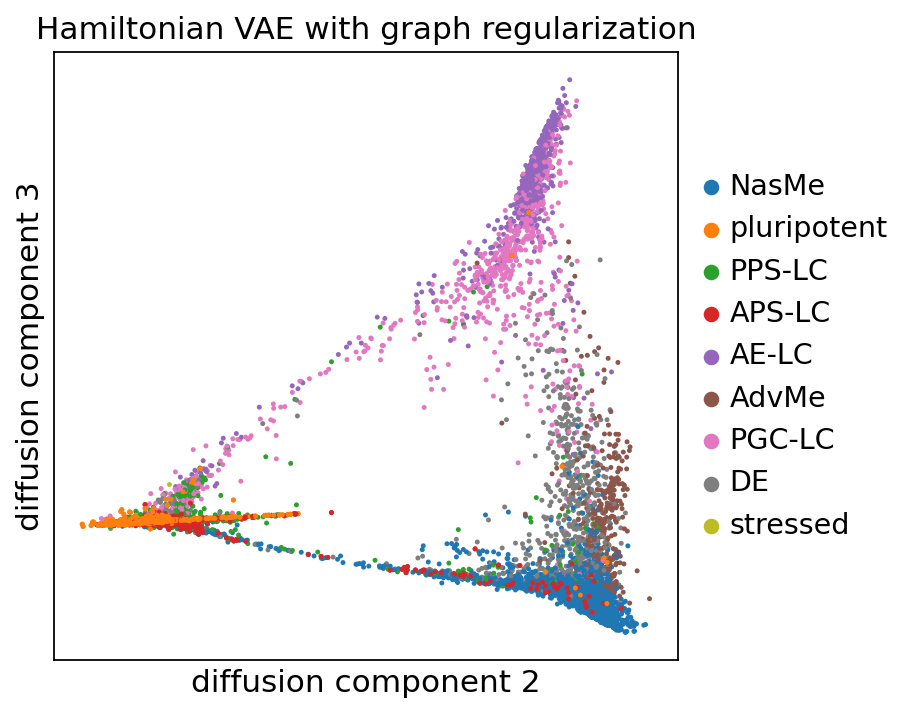

In [ ]:
ax = sc.pl.embedding(
    adata,
    basis="X_diffmap_vae",
    components="2,3",
    color=["leiden"],
    size=20,
    show=False,
)
sc.pl.embedding(
    adata[adata.obs["leiden"].str.contains("pluri|APS")],
    basis="X_diffmap_vae",
    components="2,3",
    color=["leiden"],
    size=20,
    show=False,
    ax=ax,
    legend_loc=None,
)
ax.set_xlabel("diffusion component 2")
ax.set_ylabel("diffusion component 3")
ax.set_title("Hamiltonian VAE with graph regularization")
plt.savefig("/home/stanfish/zhiyu/Desktop/HVAE.png", dpi=300, bbox_inches="tight")

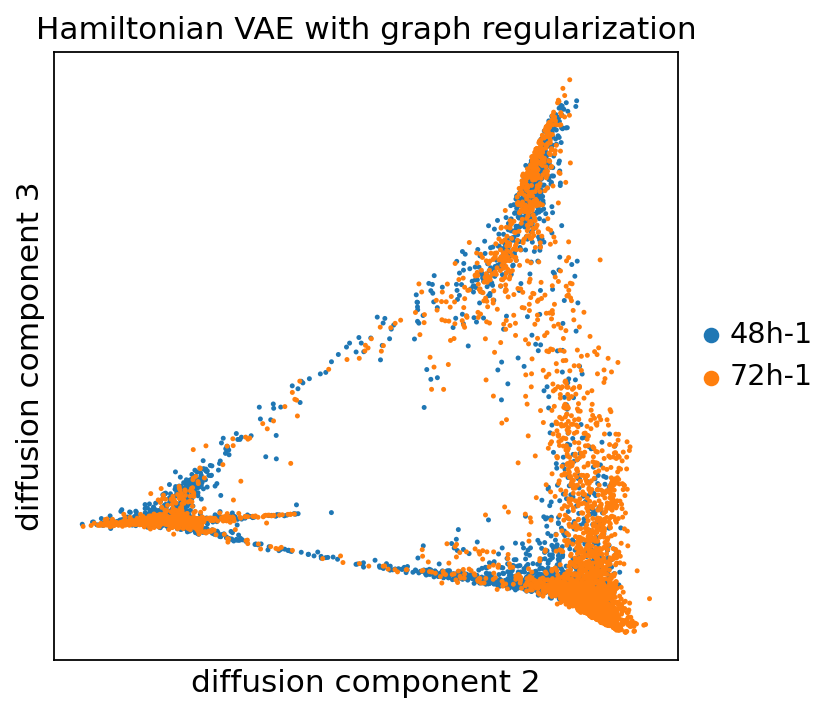

In [83]:
ax = sc.pl.embedding(
    adata,
    basis="X_diffmap_vae",
    components="2,3",
    color=["sample_labels"],
    size=20,
    show=False,
)
ax.set_xlabel("diffusion component 2")
ax.set_ylabel("diffusion component 3")
ax.set_title("Hamiltonian VAE with graph regularization")
plt.savefig("/home/stanfish/zhiyu/Desktop/HVAE_sl.png", dpi=300, bbox_inches="tight")

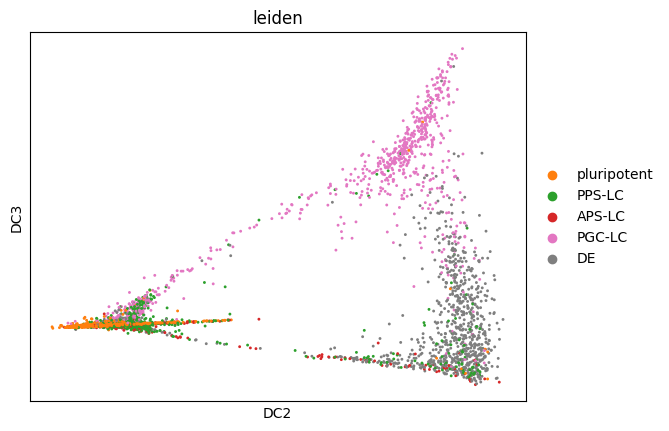

In [36]:
comp = (2, 3)
ax = sc.pl.diffmap(
    adata[adata.obs["leiden"].str.contains("pluri|PS|PGC|DE")],
    components=f"{comp[0]},{comp[1]}",
    color="leiden",
    show=False,
)
# ax.set_xlim(np.percentile(adata.obsm["X_diffmap"][:, comp[0] - 1], [1, 99]))
# ax.set_ylim(np.percentile(adata.obsm["X_diffmap"][:, comp[1] - 1], [1, 99]))

In [85]:
adata.write_h5ad("adata_48_72.h5ad")

In [ ]:
# trainer.save_checkpoint("hvae_model_7_8.ckpt")

# Mouse and monkey

In [3]:
adata = sc.read_h5ad("../../persistent-homology/data/adata_monkey_mouse_processed.h5ad")

In [4]:
# adata is already log transformed
# neighbor calculation for each batch
sc.pp.subsample(adata, fraction=0.6, random_state=1)
adata_list = []
start_obs_idx = 0
n_neighbors = 10
obs_idx = np.arange(adata.shape[0], dtype=np.int64)
obs_nei_idx = -np.ones([adata.shape[0], n_neighbors], dtype=np.int64)
obs_nei_conn = np.zeros([adata.shape[0], n_neighbors], dtype=np.float32)

for sp in tqdm(adata.obs["sample_labels"].cat.categories):
    adata_temp = adata[adata.obs["sample_labels"] == sp].copy()
    sc.pp.pca(adata_temp, n_comps=100)
    sc.pp.neighbors(adata_temp, method="gauss", n_neighbors=n_neighbors)
    row_idx, col_idx = adata_temp.obsp["connectivities"].nonzero()
    conn = adata_temp.obsp["connectivities"].data
    for i in np.unique(row_idx):
        nei_idx = col_idx[row_idx == i] + start_obs_idx
        nei_conn = conn[row_idx == i]
        # in case there are more than n_neighbors, get n_neighbors closest
        if len(nei_idx) > n_neighbors:
            # Sort by connection strength (descending) and keep top n_neighbors
            sorted_indices = np.argsort(nei_conn)[::-1][:n_neighbors]
            nei_idx = nei_idx[sorted_indices]
            nei_conn = nei_conn[sorted_indices]
        obs_nei_idx[i + start_obs_idx, 0 : len(nei_idx)] = nei_idx
        obs_nei_conn[i + start_obs_idx, 0 : len(nei_idx)] = nei_conn
    adata_list.append(adata_temp)
    start_obs_idx += adata_temp.shape[0]
adata = sc.concat(adata_list)


100%|██████████| 40/40 [01:50<00:00,  2.75s/it]


In [5]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
x = adata.X.toarray().round()
c = pd.get_dummies(adata.obs["sample_labels"]).values
c_extra = pd.get_dummies(adata.obs["species"]).values.astype(np.float32)
c = np.concatenate([c, c_extra], 1)
x = torch.from_numpy(x.astype(np.float32))
c = torch.from_numpy(c.astype(np.float32))
obs_idx = torch.from_numpy(obs_idx)
obs_nei_idx = torch.from_numpy(obs_nei_idx)
obs_nei_conn = torch.from_numpy(obs_nei_conn)

In [6]:
adata.shape

(98434, 1850)

In [7]:
dataset = TensorDataset(x, c, obs_idx, obs_nei_idx, obs_nei_conn)
data_loader = DataLoader(dataset, batch_size=1024 * 2, shuffle=True)

In [18]:
# --- Model setup ---
input_dim = x.shape[1]
condition_dim = c.shape[1]
hidden_dim = 256
latent_dim = 40
output_dim = x.shape[1]

# Instantiate Encoder and Decoder
encoder = Encoder(
    input_dim=input_dim,
    condition_dim=condition_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
)

decoder = Decoder(
    output_dim=output_dim,
    condition_dim=condition_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
)

# Instantiate the HVAE model
model = HVAE(
    Encoder=encoder,
    Decoder=decoder,
    nLeapFrog=15,
    InitLeapFrogStep=0.005,
    MaxLeapFrogStep=0.1,
    init_alpha=1.0,  # 0.9
    lr=1e-3,
    beta=1.0,
    GraphRegWeight=0.0,
    MMD=0.0,
    MMDdim=latent_dim,
    MMDgamma=0.01,
    USE_VAMP=True,
    VAMP_K=100,
)

# --- Training ---
# Use PyTorch Lightning's Trainer
# You can add callbacks, logging, etc. here
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",  # Automatically selects GPU/CPU
)

# Train the model
trainer.fit(model, data_loader)

/home/stanfish/Git/vae/scripts/vae_v6.py:111: RuntimeWarning: divide by zero encountered in divide
  init_alphas_reparam = np.log(init_alphas / (1 - init_alphas))
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | Encoder      | Encoder | 585 K  | train
1 | Decoder      | Decoder | 575 K  | train
  | other params | n/a     | 7.8 M  | n/a  
-------------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.729    Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
/hom

Epoch 9: 100%|██████████| 49/49 [05:08<00:00,  0.16it/s, v_num=35, loss=1.85e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 49/49 [05:08<00:00,  0.16it/s, v_num=35, loss=1.85e+3]


In [19]:
data_loader_inference = DataLoader(dataset, batch_size=1024 * 2, shuffle=False)
z_k = None

for batch in tqdm(data_loader_inference):
    x_batch, c_batch, _, _, _ = batch
    z_k_batch = model.get_latent_representation(x_batch, c_batch, K=5)
    if z_k is None:
        z_k = z_k_batch.cpu().detach().numpy()
    else:
        z_k = np.concatenate([z_k, z_k_batch.cpu().detach().numpy()])
    del z_k_batch, x_batch, c_batch
    gc.collect()
    torch.cuda.empty_cache()

adata.obsm["X_vae"] = z_k
del z_k

100%|██████████| 49/49 [18:44<00:00, 22.94s/it]


In [20]:
adata.obsm["X_diffmap_scvi"] = adata.obsm["X_diffmap"]
del adata.obsm["X_diffmap"]

In [20]:
sc.tl.diffmap(adata, neighbors_key="scvi", n_comps=25)

In [16]:
sc.pp.neighbors(
    adata, use_rep="X_scvi", key_added="scvi", n_neighbors=20, method="gauss"
)
sc.tl.diffmap(adata, neighbors_key="scvi")
sc.tl.umap(adata, neighbors_key="scvi")
adata.obsm["X_diffmap_scvi"] = adata.obsm["X_diffmap"]

In [25]:
sc.pp.neighbors(adata, use_rep="X_vae", key_added="vae", n_neighbors=20, method="gauss")
sc.tl.diffmap(adata, neighbors_key="vae", n_comps=25)
sc.tl.umap(adata, neighbors_key="vae")
adata.obsm["X_diffmap_vae"] = adata.obsm["X_diffmap"]

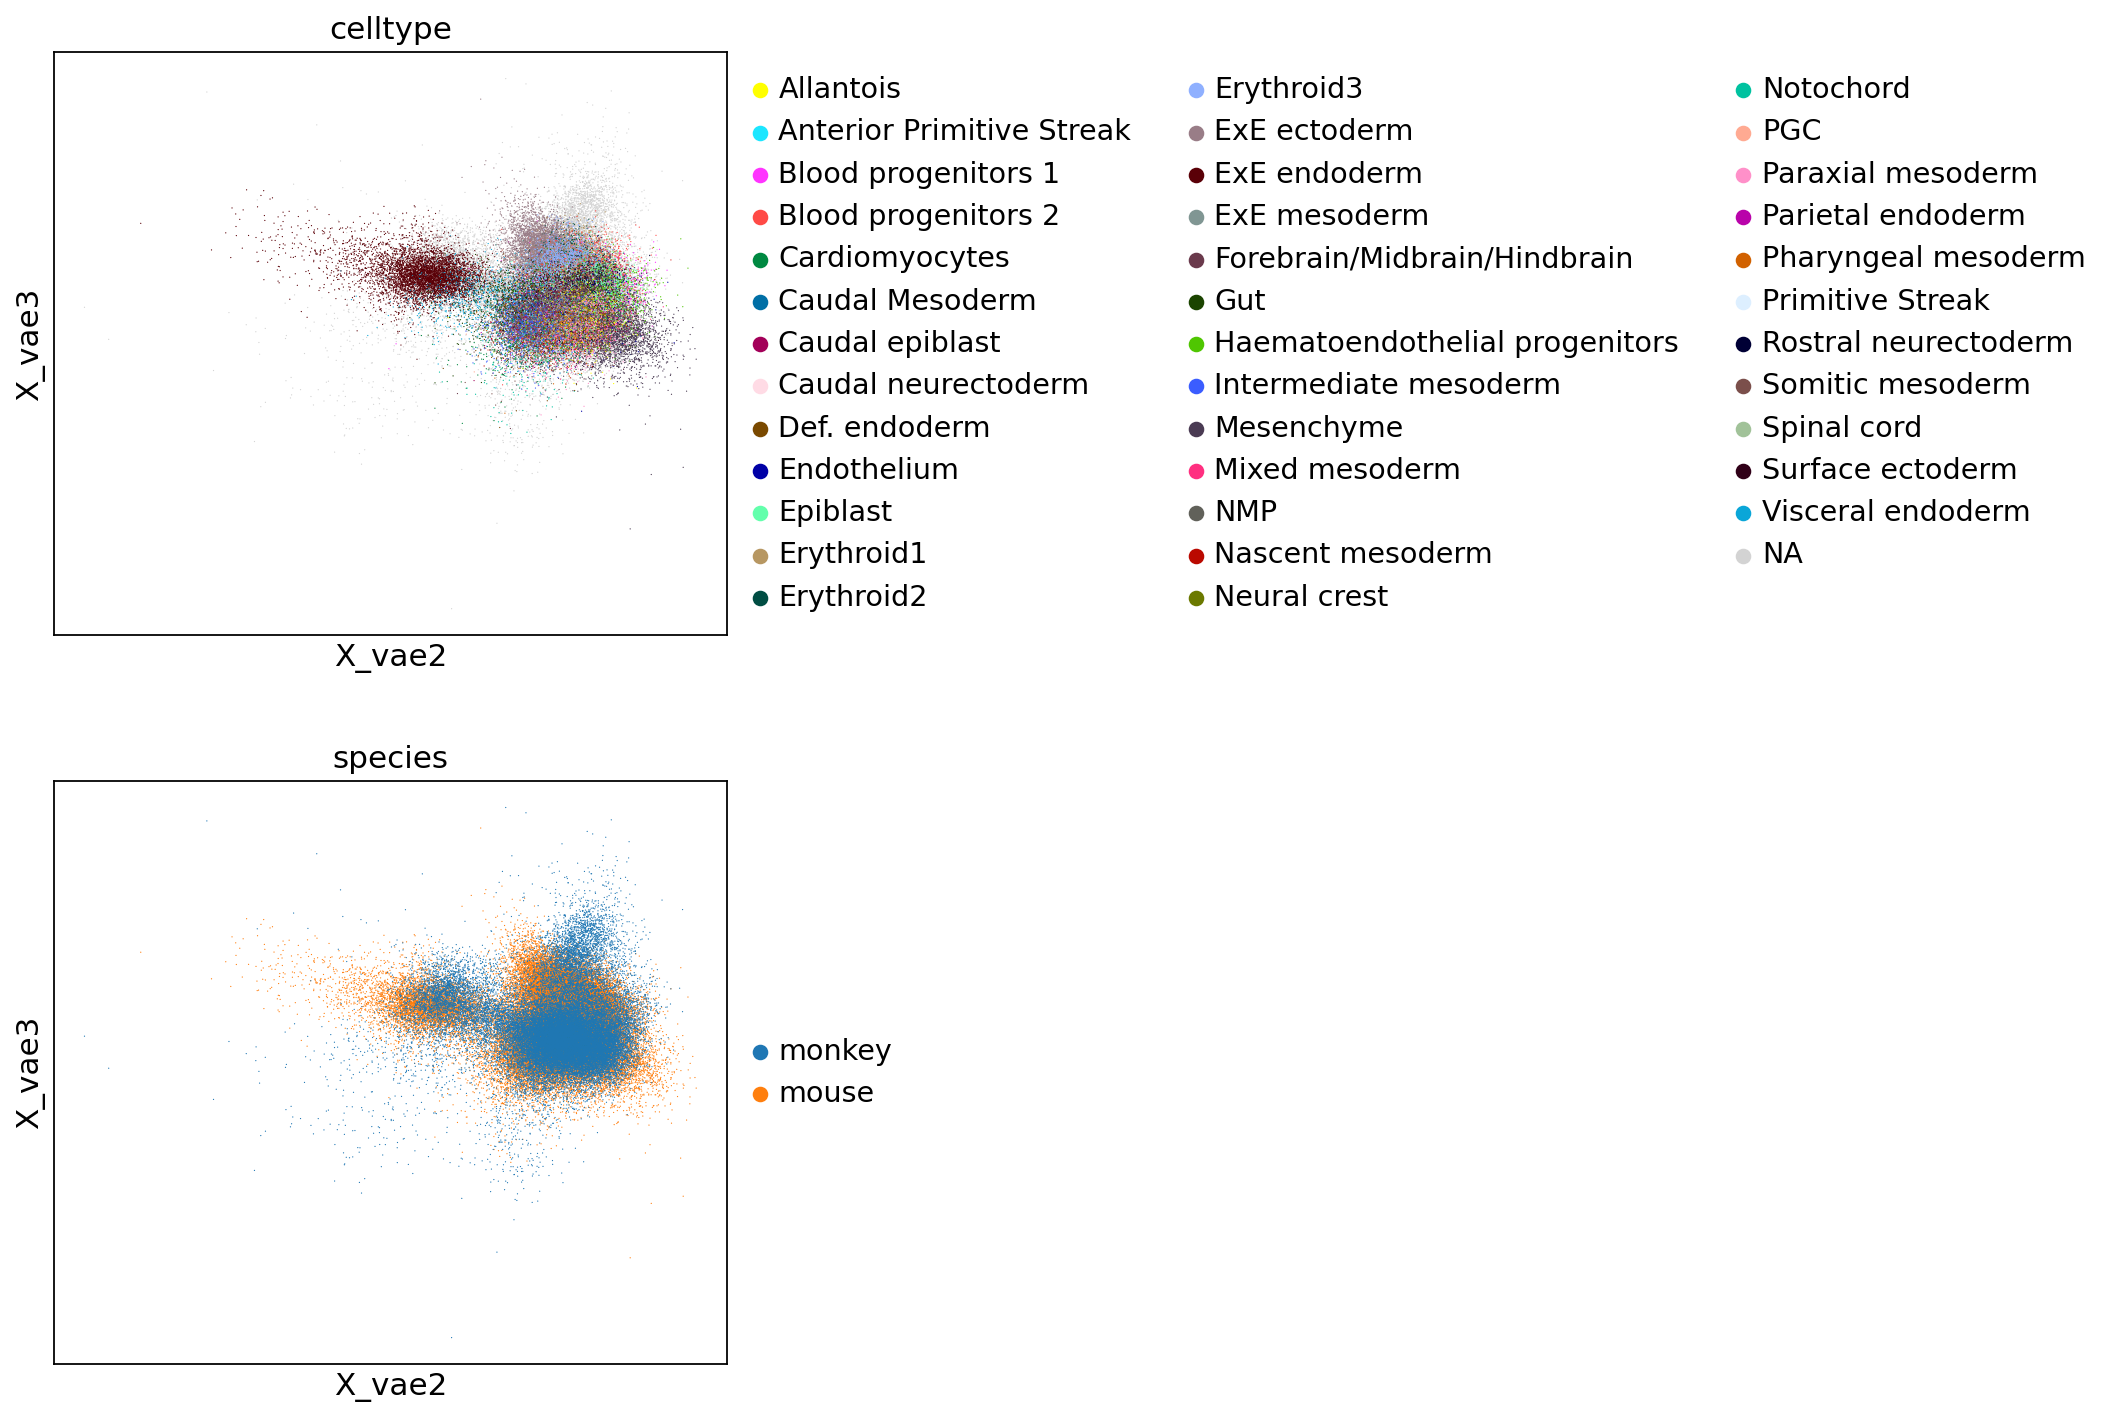

In [26]:
ax = sc.pl.embedding(
    adata,
    color=["celltype", "species"],
    basis="X_vae",
    components="2,3",
    show=False,
    ncols=1,
)

# ax.set_xlabel("HVAE component 1")
# ax.set_ylabel("HVAE component 2")
# ax.set_title("Hamiltonian VAE enables more flexible latent manifold")
# plt.savefig(
#     "/home/stanfish/zhiyu/Desktop/HVAE_latent.png", dpi=300, bbox_inches="tight"
# )

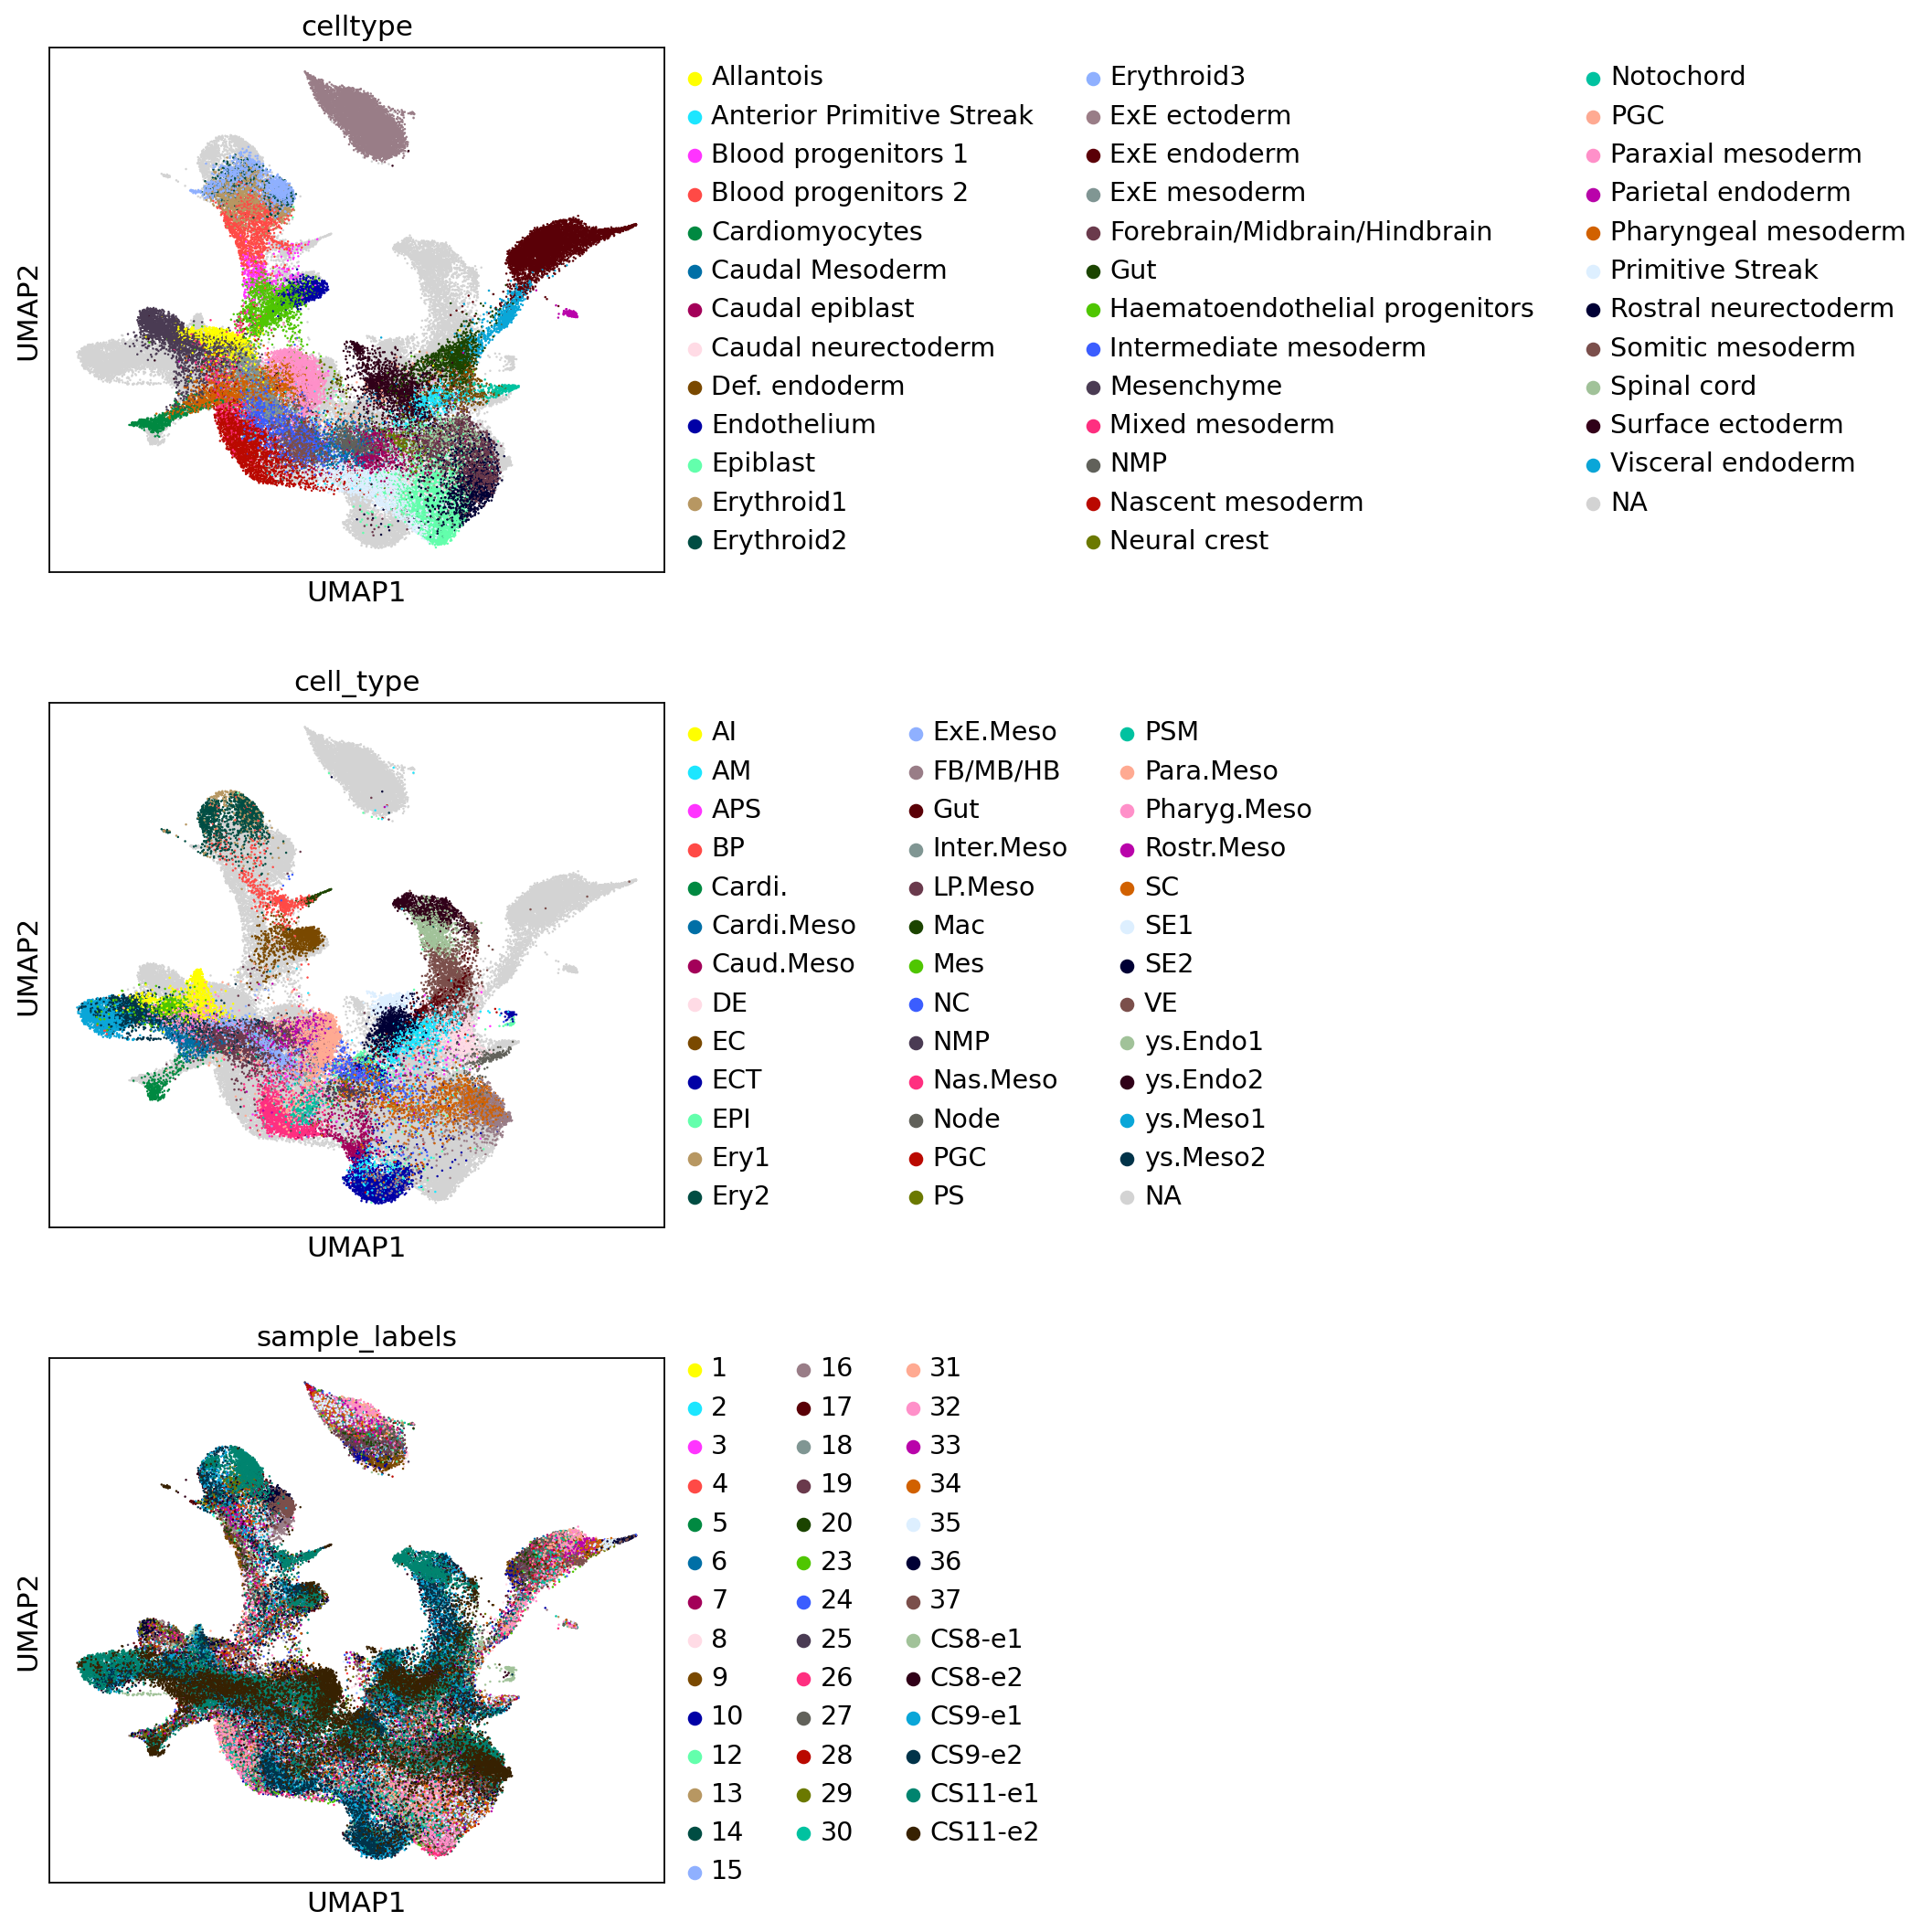

In [27]:
sc.pl.umap(
    adata,
    color=["celltype", "cell_type", "sample_labels"],
    ncols=1,
    size=5,
    # legend_loc="on data",
)

In [28]:
sc.pp.neighbors(adata, use_rep="X_vae", key_added="vae", n_neighbors=50, method="gauss")
sc.tl.diffmap(adata, neighbors_key="vae", n_comps=25)

In [95]:
adata.write_h5ad("monkey_mouse_integrate_loop.h5ad")

In [29]:
import pathlib
from itertools import combinations

save_dir = pathlib.Path("./img_dump/monkey_diffmap_4")
save_dir.mkdir(exist_ok=True, parents=True)
overwrite = True

for i, j in combinations(range(25), 2):
    if overwrite or not (save_dir / f"diffmap_{i}_{j}.png").exists():
        adata_sub = adata[
            np.logical_or(
                adata.obs["cell_type"].str.contains(
                    "Para.Meso|PSM|NMP|Nas|EPI|^PS", na=False
                ),
                adata.obs["celltype"].str.contains(
                    "Epi|^Primi|Nascent|Somitic|Paraxial|Caudal|NMP", na=False
                ),
            )
        ]
        axes = sc.pl.embedding(
            adata_sub,
            basis="X_diffmap",
            color=["cell_type", "celltype"],
            components=f"{i + 1},{j + 1}",
            # legend_loc="on data",
            ncols=2,
            size=50,
            show=False,
            na_in_legend=False,
            frameon=False,
            title=["", ""],
            # xlim=[0, 100]
        )
        for ax in axes:
            ax.set_xlim(np.percentile(adata_sub.obsm["X_diffmap"][:, i], [0.1, 99.9]))
            ax.set_ylim(np.percentile(adata_sub.obsm["X_diffmap"][:, j], [0.1, 99.9]))
        plt.savefig(
            save_dir / f"diffmap_{i + 1}_{j + 1}.png", dpi=100, bbox_inches="tight"
        )
        plt.close()